In [1]:
import os.path as op
from glob import glob

from neuromaps.datasets import fetch_atlas, fetch_fslr
from netneurotools import stats as nnstats
from surfplot.utils import add_fslr_medial_wall
from joblib import Parallel, delayed
import numpy as np
import nibabel as nib

# Spin Permutation example

In [2]:
coords = np.array([[0, 0, 1], [1, 0, 0], [0, 0, 1], [1, 0, 0]])
hemi = [0, 0, 1, 1]
null_sample = nnstats.gen_spinsamples(
    coords, 
    hemi, 
    n_rotate=3,
    seed=1, 
    method='vasa', 
    check_duplicates=True
)

In [3]:
def _gen_spinsamples(coords, hemi, seed):
    null_sample = nnstats.gen_spinsamples(
        coords, 
        hemi, 
        n_rotate=1,
        seed=seed, 
        method='vasa', 
        check_duplicates=True
    )
    return null_sample

In [5]:
results = Parallel(n_jobs=4, max_nbytes=None)(
            delayed(_gen_spinsamples)(coords, hemi, seed) for seed in range(10))
permutes = np.hstack(results)
permutes

array([[1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [3, 2, 2, 3, 3, 2, 2, 3, 3, 3],
       [2, 3, 3, 2, 2, 3, 3, 2, 2, 2]])

## Real data fsLR

In [6]:
data_dir = op.abspath("../data")
result_dir = op.abspath("../results")
neuromaps_dir = op.join(data_dir, "neuromaps-data")

In [7]:
from surfplot import Plot
from surfplot.utils import threshold

surfaces = fetch_fslr(density="32k", data_dir=neuromaps_dir)
lh, rh = surfaces["inflated"]
sulc_lh, sulc_rh = surfaces["sulc"]

def plot_surf_map(lh_grad, rh_grad, threshold_=None, cmap=None, color_range=None):
    if threshold_ is not None:
        lh_grad = threshold(lh_grad, threshold_)
        rh_grad = threshold(rh_grad, threshold_)

    p = Plot(surf_lh=lh, surf_rh=rh)
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer({"left": lh_grad, "right": rh_grad}, cmap=cmap, color_range=color_range)

    fig = p.build()

In [8]:
nullsamples_fn = op.join(result_dir, "gradient_decoding", "null_samples_fslr.npy")
atlas = fetch_atlas("fsLR", "32k", data_dir=neuromaps_dir, verbose=0)

medial_lh, medial_rh = atlas["medial"]
medial_arr_lh = nib.load(medial_lh).agg_data()
medial_arr_rh = nib.load(medial_rh).agg_data()

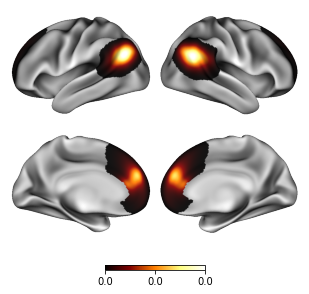

In [9]:
gclda_grad_path = op.join(result_dir, "gradient_decoding", "gclda-fslr")

gclda_grad_lh_fnames = sorted(glob(op.join(gclda_grad_path, "*hemi-L_feature.func.gii")))[0]
gclda_grad_rh_fnames = sorted(glob(op.join(gclda_grad_path, "*hemi-R_feature.func.gii")))[0]
lh_grad = nib.load(gclda_grad_lh_fnames).agg_data()
rh_grad = nib.load(gclda_grad_rh_fnames).agg_data()

plot_surf_map(lh_grad, lh_grad, threshold_=0.000001, cmap="afmhot")

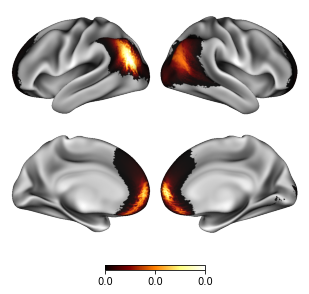

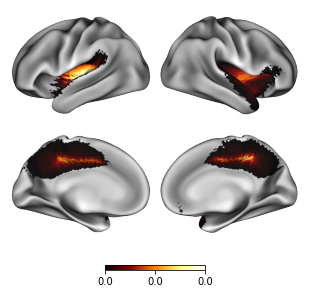

In [10]:
lh_grad_permuted = lh_grad[np.where(medial_arr_lh != 0)]
rh_grad_permuted = rh_grad[np.where(medial_arr_rh != 0)]
grad_map_permuted = np.hstack((lh_grad_permuted, rh_grad_permuted))

null_samples = np.load(nullsamples_fn)
grad_map_permuted = grad_map_permuted[null_samples]

for perm_i in range(grad_map_permuted.shape[1]):
    grad_permuted = add_fslr_medial_wall(grad_map_permuted[:, perm_i], split=False)
    full_vertices = grad_permuted.shape[0]
    hemi_vertices = int(full_vertices / 2)
    
    lh_grad_permuted, rh_grad_permuted = grad_permuted[:hemi_vertices], grad_permuted[hemi_vertices:full_vertices]

    plot_surf_map(lh_grad_permuted, rh_grad_permuted, threshold_=0.000001, cmap="afmhot")